In [ ]:
using Plots
using LaTeXStrings, ColorSchemes
using CSV, DataFrames
Plots.PyPlotBackend()

function fluid_plot(sol, time_skip, save_every, x, s, tmax; hmax=Inf)
    dt = floor(Int64, time_skip / save_every)
    plt = plot(x, s, dpi=200, xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$", legend=false, color="black",
        title=L"Fluid profile at $\delta t = %$time_skip$ intervals", ylims=(0, hmax), xlims=(0, Lx))
    for i = 1:floor(Int64, tmax / time_skip)+1
        plot!(plt, x, sol.u[1+dt*(i-1)][2:end-1] + s)
    end
    plot!(plt, x, s, color="black")
    return plt
end

function fluid_plot_no_title(sol, time_skip, save_every, x, s, tmax; hmax=Inf)
    dt = floor(Int64, time_skip / save_every)
    plt = plot(x, s, dpi=200, xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$", legend=false, color="black",
        ylims=(0, hmax), xlims=(0, Lx))
    for i = 1:floor(Int64, tmax / time_skip)+1
        plot!(plt, x, sol.u[1+dt*(i-1)][2:end-1] + s)
    end
    plot!(plt, x, s, color="black")
    return plt
end

function fluid_anim(sol, ymax, xmax, x, s)
    anim = @animate for i = 1:size(sol.u)[1]
        timestep = sol.t[i]
        plot(x, sol.u[i][2:end-1] + s, dpi=200, legend=false, ylims=(0, ymax), xlims=(0, Lx), title=L"Fluid Profile $(t=%$timestep)$",
            xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$")
        plot!(x, s, color="black")
    end
    return anim
end

"""
Function to save fluid profile data to a CSV. CSV saved in the format of:
Timestamp | Ghost 1 | 0 | ... | Lx | Ghost 2
# Arguments
- `sol`: solution object of DiffEq solver
"""
function fluid_data(sol, path)
    CSV.write(path * "/data.csv", DataFrame(sol))
end

function save_params(path, filename="params")
    open(path * "/" * filename * ".txt", "w") do f
        domain_info = "# Domain Parameters\nnx: $nx\nLx: $Lx\ndx: $dx\n"
        topo_info = "\n# Topography Parameters\n$topo\n"
        init_cond_info = "\n# Initial Condition Parameters\n$ic_obj\n"
        ode_sys_info = "\n# ODE System Parameters\nBo: $Bo\nWe_ac: $We_ac\nalpha: $α\nepsilon: $ϵ\nalpha_1: $α_1\n"
        time_info = "\n# Time Parameters\ntime_span: $tspan\ntimestep_save: $save_every"
        write(f, domain_info * topo_info * init_cond_info * ode_sys_info * time_info)
    end
end

In [ ]:
"""
Custom struct for topogrpahy functions
"""
struct Topography
    f::Function
    params::Tuple
end

"""
Function describing a flat plane
"""
function flat(x)
    0
end

"""
Function describing a bump
# Arguments
- `x`: x coordinate
- `w`: width scaling
- `c`: x coordinate for the center of the bump
- `h`: optional arg for height scaling
"""
function bump(x, w, c, h=1)
    if x <= c - w || x >= c + w
        return 0
    else
        return h * exp(-(w^2 / (w^2 - (x - c)^2)))
    end
end

"""
Function describing a rectangular mound
# Arguments
- `x`: x coordinate
- `c`: x coordinate for left hand corner of mound
- `h`: height of mound
- `delta`: steepness of mound
- `w`: width of mound
"""
function mound(x, c, h, delta, w)
    h * (1 / pi * (atan((x - c) / delta) - atan((x - c - w) / delta)))
end

"""
Custom struct for initial condition functions
"""
struct InitialCondition
    f::Function
    params::Tuple
end

"""
Function describing a reflected sigmoid
# Arguments
- `x`: x coordinate
- `b`: precursor film height
- `xf`: center point of transition
- `c`: steepness of transition
- `h`: optional argument control initial height
"""
function reflected_sigmoid(x, b, xf, c, h=1)
    b + (h - b) / (1 + exp(1 / c * (x - xf)))
end

"""
Function describing a flat plane with respect to phi = 0
# Arguments
- `h`: film height relative to phi = 0
- `s`: topography
"""
function flat_profile(x, h, s, b=0.0)
    h - s + b
end

function front_tanh(x)
    0.45 * tanh(-5 * (x - 5)) + 0.55
end

"""
Function describing a bump
# Arguments
- `x`: x coordinate
- `w`: width scaling
- `c`: x coordinate for the center of the bump
- `b`: precursor film height
- `h`: optional arg for height scaling
"""
function ic_bump(x, w, c, b, h=1)
    if x <= c - w || x >= c + w
        return b
    else
        return h * exp(-(w^2 / (w^2 - (x - c)^2))) + b
    end
end

In [96]:
plot_font = "Computer Modern"
default(fontfamily=plot_font, grid=false)
# ================================
# Discretization of x-domain
# ================================
Lx = 100
dx = 0.05

nx = Lx / dx
x = 0.0:dx:Lx

# ================================
# Topography definition
# ================================
#topo = Topography(flat, ())
topo = Topography(bump, (15, 50.0, ℯ*(.1)))
s = topo.f.(x, topo.params...)

# ================================
# Initial Condition definition
# ================================
b = 0.01
c = 10
w = 10
h = ℯ*(1-b)
ic_obj = InitialCondition(ic_bump, (w, c, b, h))
ic = ic_obj.f.(x, ic_obj.params...)

# Adding ghost points
pushfirst!(ic, ic[1])
push!(ic, ic[end])

# ================================
# Parameters of the system of ODEs
# ================================

α = 0
g = 9.8 # m/s^2

# Oil Physical Properties
ρ = 900 # kg/m^3
γ = 20 * 10^(-3) # kg/s^2
μ = 0.045 # kg*m/s

# Saw Forcing Properties
A = 8 * 10^(-10) # m 
ω = 40 * pi * 10^6 # 1/s
α_1 = 2.386
#k_i = -0.7683

# Scaling Factors
h_c = 200 * 10^(-6)
x_c = 10^(-3)
ϵ = h_c / x_c
t_c = (3 * μ * x_c^4) / (h_c^3 * γ)

# Dimless Params
Bo = (x_c^2 * ρ * g) / γ
We_ac = (ρ * ω^2 * A^2 * x_c) / γ

xsym = Symbol.(x)
pushfirst!(xsym, Symbol("ghost1"))
push!(xsym, Symbol("ghost2"))
print("End")

End

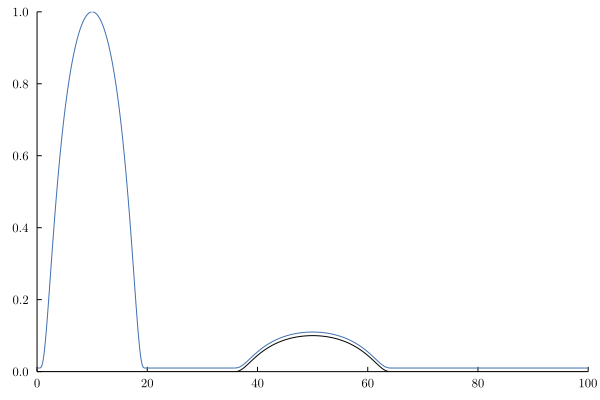

In [97]:
asdf = plot(x, s, legend=false, color="black", xlims=(0, Lx), ylims=(0, 1))
plot(asdf, x, ic[2:end-1]+s)

In [ ]:
"""
Builds the system of ODEs (represented by du)
u = (h_-1, h_0, ..., h_nx, h_nx+1) where h_-1 and h_nx+1 are ghost points
"""
function system!(dh, h, p, t)
    α, dx, Bo, We_ac, ϵ, α_1, x_c, topo, params, b, λ, α_oil, α_air = p

    function phi(i)
        h[i] + topo(dx * (i-2), params...)
    end
    function interp(i)
        1/2 * (h[i]^3 + h[i+1]^3)
    end
    function f1(i)
        1/(dx^2) * (interp(i-1) * (phi(i-1) - phi(i)) + interp(i)*(phi(i+1) - phi(i)))
    end
    function f2(i)
        1 /(dx^4) * (interp(i-1) * (phi(i-2) - 3*phi(i-1) + 3*phi(i) - phi(i+1)) + interp(i) * (-phi(i-1) + 3*phi(i) - 3*phi(i+1) + phi(i+2)))
    end
    function f3(i)
        1/(2*dx) * (h[i+1]^3 - h[i-1]^3)
    end
    function f4(i, atten)

        function exp_term(j)
            x_j = dx * (j - 2)
            return exp(2 * atten * x_j)
        end
        function cdiff(j)
            return 1/(2*dx) * (phi(j+1) - phi(j-1))
        end

        (1/(2*dx)) * ((h[i+1]^3 * exp_term(i+1) * (1 + α_1*ϵ*cdiff(i+1))) - (h[i-1]^3 * exp_term(i-1) * (1 + α_1*ϵ*cdiff(i-1))))
        #(1/(2*dx)) * (expo(i)*(u[i+1]^3 + u[i]^3) - expo(i-1)*(u[i]^3 + u[i-1]^3))
    end
    function atten_c(h, b, λ, α_oil, α_air)
        h_bar = h - b   
        return x_c*((α_oil - α_air)*(1 - exp(-h_bar / λ)) + α_air)
    end

    dh[1] = 0
    dh[2] = 0
    dh[end-1] = 0
    dh[end] = 0
    for i in 3:length(h)-2
        atten = atten_c(phi(i), b, λ, α_oil, α_air)
        C = ((1+α_1^2)*We_ac*atten)/ϵ
        dh[i] = (Bo * cos(α))*f1(i) - f2(i) - (sin(α) * Bo/ϵ)*f3(i) + C*f4(i, atten)
    end 
    return dh
end

In [98]:
using DifferentialEquations

λ = 2 * 10^(-3)
p = [α, dx, Bo, We_ac, ϵ, α_1, x_c, topo.f, topo.params, b, λ/x_c, -1000, -1]
#tspan = (0.0, 5*10^4)
#save_every = 10^2
tspan = (0.0, 200000.0)
save_every = 100
f = ODEFunction(system!, syms=xsym)
prob = ODEProblem(f, ic, tspan, p, saveat=save_every)
sol = solve(prob, alg=Rodas4())
#print("END")

plot_font = "Computer Modern"
default(fontfamily=plot_font, grid=false, color=ColorSchemes.oslo[120])

time_skip = 100
hmax = 1
plt = fluid_plot(sol, time_skip*save_every, save_every, x, s, tspan[2]; hmax=hmax)
anim = fluid_anim(sol, hmax, Lx, x, s)
plt_notitle = fluid_plot_no_title(sol, time_skip*save_every, save_every, x, s, tspan[2]; hmax=hmax)

using Dates

date = string(Dates.format(now(), "YYYYmmdd"))
time = string(Dates.format(now(), "HHMMSS"))
path = "../runs/$date/$time"

mkpath(path)

gif(anim, path * "/flow.gif", fps = 30)
savefig(plt, path * "/plt.png")
savefig(plt_notitle, path * "/plt_notitle.png")
fluid_data(sol, path)
save_params(path)

┌ Info: Saved animation to 
│   fn = /Users/bsamineni/Documents/research_projects/acoustics_thin_film/project/runs/20220425/010607/flow.gif
└ @ Plots /Users/bsamineni/.julia/packages/Plots/rDbWY/src/animation.jl:114


394

In [ ]:
plot_font = "Computer Modern"
default(fontfamily=plot_font, grid=false, color=ColorSchemes.oslo[120])

time_skip = 100
plt = fluid_plot(sol, time_skip*save_every, save_every, x, s, tspan[2]; hmax=0.5)
anim = fluid_anim(sol, 0.5, Lx, x, s)

using Dates

date = string(Dates.format(now(), "YYYYmmdd"))
time = string(Dates.format(now(), "HHMMSS"))
path = "../runs/$date/$time"

mkpath(path)

gif(anim, path * "/flow.gif", fps = 30)
savefig(plt, path * "/plt.png")
fluid_data(sol, path)
save_params(path)


In [ ]:
plt

In [ ]:
gif(anim, fps=30)

In [ ]:
struct SolutionObj
    t::Vector{Float64}
    u::Vector{Vector{Float64}}
end

df = DataFrame(CSV.File("../runs/20220423/193247/data.csv"))
m = Matrix(df)
t = m[:, 1]
u = [m[i, 2:end] for i in 1:size(m, 1)]
sol = SolutionObj(t, u)
print("End")

In [ ]:
plot_font = "Computer Modern"
default(fontfamily=plot_font, grid=false, color=ColorSchemes.oslo[120])

function fluid_plot_no_title(sol, time_skip, save_every, x, s, tmax; hmax=Inf)
    dt = floor(Int64, time_skip / save_every)
    plt = plot(x, s, dpi=200, xlabel=L"Dimensionless length $x$", ylabel=L"Dimensionless free surface height $\phi$", legend=false, color="black",
        ylims=(0, hmax), xlims=(0, Lx))
    for i = 1:floor(Int64, tmax / time_skip)+1
        plot!(plt, x, sol.u[1+dt*(i-1)][2:end-1] + s)
    end
    plot!(plt, x, s, color="black")
    return plt
end

plt = fluid_plot_no_title(sol, time_skip*save_every, save_every, x, s, tspan[2]; hmax=0.5)
#anim = fluid_anim(sol, 1, Lx, x, s)

using Dates

date = string(Dates.format(now(), "YYYYmmdd"))
time = string(Dates.format(now(), "HHMMSS"))
path = "../runs/$date/$time"

mkpath(path)

#gif(anim, path * "/flow.gif", fps = 30)
savefig(plt, path * "/plt.png")